# Assignment 4: Data Collection and Analysis
## 프로젝트: Aero-Post Generator (항공 뉴스 캡션 자동 생성기)

### 개요
본 분석은 Assignment 3에서 제안한 프로젝트를 위해 수집된 **항공 뉴스 데이터(AeroRoutes)**의 특성을 파악하고, 향후 ML 모델 학습을 위한 전처리 전략을 수립하기 위해 수행되었다.

- **데이터 출처**: [AeroRoutes](https://www.aeroroutes.com/)
- **수집 방법**: Python `requests` 및 `BeautifulSoup`을 활용한 크롤링
- **데이터 크기**: 총 1,000개

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import random

# 1. 저장할 폴더
if not os.path.exists('data'):
    os.makedirs('data')

def get_detail_content_robust(url):
    """상세 페이지 내용 수집 (실패 시 재시도 로직 포함)"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200: return ""

        soup = BeautifulSoup(response.text, 'html.parser')

        # 본문 찾기 (여러 클래스 시도)
        for class_name in ['entry-content', 'sqs-block-content', 'BlogList-item-excerpt']:
            content_div = soup.find('div', class_=class_name)
            if content_div:
                return content_div.get_text(strip=True)

        # 정 안되면 전체 텍스트
        return soup.get_text(strip=True)[:2000]
    except:
        return ""

def scrape_aeroroutes_marathon(target_count=1000):
    base_url = "https://www.aeroroutes.com"
    current_url = "https://www.aeroroutes.com/eng"
    headers = {'User-Agent': 'Mozilla/5.0'}

    articles_data = []
    page_num = 1
    save_path = 'data/aviation_data.csv'

    print(f"=== 대장정 시작: 목표 {target_count}개 ===")
    print("중간중간 자동으로 저장되니 안심하세요.")

    while len(articles_data) < target_count:
        print(f"\n[Page {page_num}] 읽는 중... (현재 {len(articles_data)}개 완료)")

        try:
            response = requests.get(current_url, headers=headers, timeout=15)
            soup = BeautifulSoup(response.text, 'html.parser')
            posts = soup.find_all('article', class_='blog-basic-grid--container')

            if not posts:
                print("더 이상 글이 없습니다.")
                break

            for post in posts:
                if len(articles_data) >= target_count: break

                title_tag = post.find('h1', class_='blog-title').find('a')
                if not title_tag: continue

                title = title_tag.get_text(strip=True)
                link_endpoint = title_tag['href']

                # 상세 수집
                content = get_detail_content_robust(base_url + link_endpoint)

                if content:
                    articles_data.append({'source': 'AeroRoutes', 'title': title, 'content': content})

                # === 중요: 50개마다 중간 저장 ===
                if len(articles_data) % 50 == 0:
                    df_temp = pd.DataFrame(articles_data)
                    df_temp.to_csv(save_path, index=False, encoding='utf-8-sig')
                    print(f"  💾 [자동 저장] {len(articles_data)}개까지 파일에 안전하게 저장됨.")

                # 서버 부하 방지 (너무 빠르면 차단됨)
                time.sleep(random.uniform(0.5, 1.5))

            # 다음 페이지로 이동
            pagination = soup.find('div', class_='older')
            if pagination and pagination.find('a'):
                current_url = base_url + pagination.find('a')['href']
                page_num += 1
            else:
                print("마지막 페이지에 도달했습니다.")
                break

        except Exception as e:
            print(f"오류 발생 (5초 대기 후 계속): {e}")
            time.sleep(5)
            continue

    return articles_data

# === 실행 ===
data = scrape_aeroroutes_marathon(target_count=1000)

# 최종 저장
if len(data) > 0:
    df = pd.DataFrame(data)
    df.drop_duplicates(subset=['title'], inplace=True) # 중복 제거
    df.to_csv('data/aviation_data.csv', index=False, encoding='utf-8-sig')
    print(f"\n[완주 성공] 총 {len(df)}개의 데이터가 저장되었습니다!")
else:
    print("데이터 수집 실패")

=== 대장정 시작: 목표 1000개 ===
중간중간 자동으로 저장되니 안심하세요.

[Page 1] 읽는 중... (현재 0개 완료)

[Page 2] 읽는 중... (현재 18개 완료)

[Page 3] 읽는 중... (현재 36개 완료)
  💾 [자동 저장] 50개까지 파일에 안전하게 저장됨.

[Page 4] 읽는 중... (현재 54개 완료)

[Page 5] 읽는 중... (현재 72개 완료)

[Page 6] 읽는 중... (현재 90개 완료)
  💾 [자동 저장] 100개까지 파일에 안전하게 저장됨.

[Page 7] 읽는 중... (현재 108개 완료)

[Page 8] 읽는 중... (현재 126개 완료)

[Page 9] 읽는 중... (현재 144개 완료)
  💾 [자동 저장] 150개까지 파일에 안전하게 저장됨.

[Page 10] 읽는 중... (현재 162개 완료)

[Page 11] 읽는 중... (현재 180개 완료)

[Page 12] 읽는 중... (현재 198개 완료)
  💾 [자동 저장] 200개까지 파일에 안전하게 저장됨.

[Page 13] 읽는 중... (현재 216개 완료)

[Page 14] 읽는 중... (현재 234개 완료)
  💾 [자동 저장] 250개까지 파일에 안전하게 저장됨.

[Page 15] 읽는 중... (현재 252개 완료)

[Page 16] 읽는 중... (현재 270개 완료)

[Page 17] 읽는 중... (현재 288개 완료)
  💾 [자동 저장] 300개까지 파일에 안전하게 저장됨.

[Page 18] 읽는 중... (현재 306개 완료)

[Page 19] 읽는 중... (현재 324개 완료)

[Page 20] 읽는 중... (현재 342개 완료)
  💾 [자동 저장] 350개까지 파일에 안전하게 저장됨.

[Page 21] 읽는 중... (현재 360개 완료)

[Page 22] 읽는 중... (현재 378개 완료)

[Page 23] 읽는 중... (현재 396개 완료)
  💾

In [15]:
# 텍스트 길이에 대한 요약 통계
length_stats = df['text_length'].describe()
print("[텍스트 길이 통계 요약]")
print(length_stats)

# 결측값 확인
missing_values = df.isnull().sum()
print("\n[결측값 확인]")
print(missing_values)

[텍스트 길이 통계 요약]
count     1000.00000
mean       580.98000
std        762.59808
min          1.00000
25%        326.00000
50%        409.50000
75%        547.00000
max      12749.00000
Name: text_length, dtype: float64

[결측값 확인]
source           0
title            0
content          0
clean_content    0
text_length      0
dtype: int64


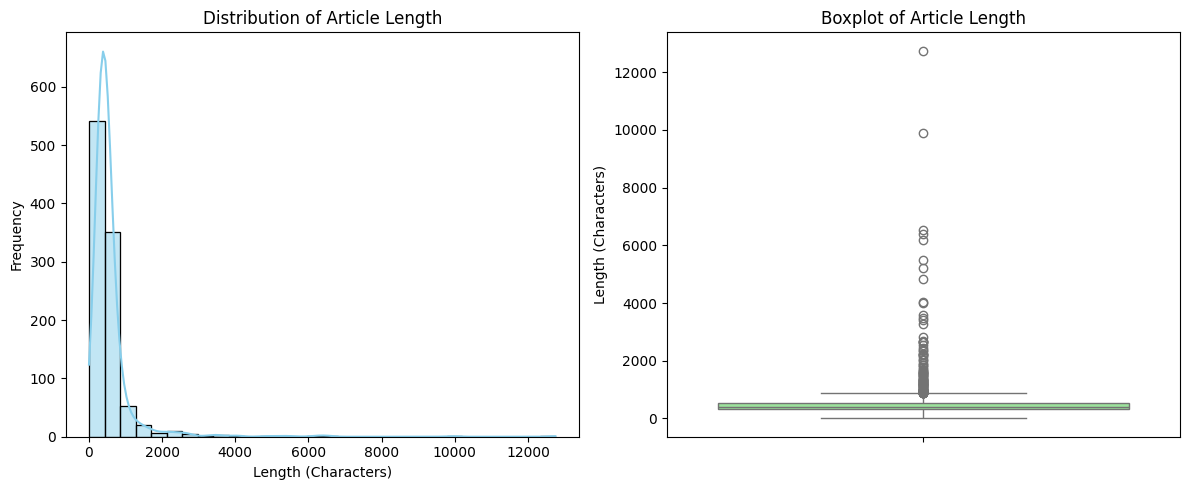

In [16]:
plt.figure(figsize=(12, 5))

# 히스토그램 (전체 분포)
plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Article Length')
plt.xlabel('Length (Characters)')
plt.ylabel('Frequency')

# 박스플롯 (이상치 확인)
plt.subplot(1, 2, 2)
sns.boxplot(y=df['text_length'], color='lightgreen')
plt.title('Boxplot of Article Length')
plt.ylabel('Length (Characters)')

plt.tight_layout()
plt.show()

### [분석 1] 텍스트 길이 분포 분석

1. **구조적 특징**
   - 데이터의 중앙값이 평균보다 낮고, 분포가 주로 **300~600자 구간**에 밀집해 있다.
   - 이는 수집된 데이터의 대다수가 매우 간결하고 핵심 정보 위주로 작성된 기사임을 알 수 있다. 불필요한 서술이 적어 모델 학습에 유리하다.

2. **이상치 (Outliers)**:
   - 박스플롯에서 확인되듯, 길이가 2,000자 이상인 긴 기사들이 일부 존재한다.
   - 확인 결과 이들은 '주간 종합 리포트(Weekly Update)' 등의 성격을 띠므로, 향후 모델 학습 시 제외하거나 분할하는 전처리가 필요하다.

/tmp/ipython-input-3134696294.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts_list), y=list(words_list), palette='viridis')


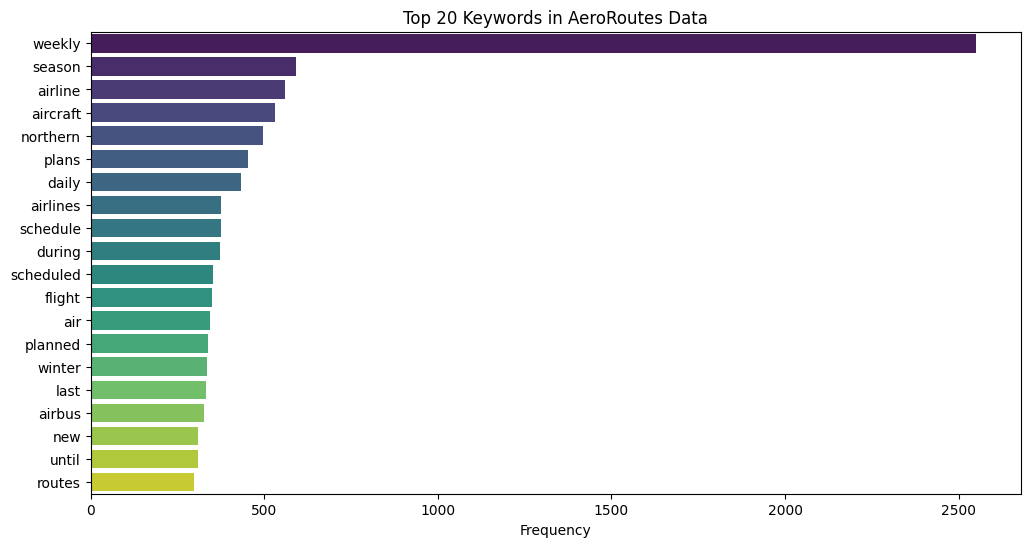

In [17]:
# 모든 텍스트를 하나로 합치고 소문자로 변환
all_text = ' '.join(df['clean_content']).lower()

# 알파벳 단어만 추출 (3글자 이상)
words = re.findall(r'\b[a-z]{3,}\b', all_text)

# 불용어(Stopwords) 제거 리스트
stopwords = set(['the', 'and', 'for', 'with', 'from', 'this', 'that', 'will', 'flights',
                 'service', 'route', 'published', 'written', 'aeroroutes'])
filtered_words = [w for w in words if w not in stopwords]

# 가장 많이 등장한 단어 20개 추출
top_20_words = Counter(filtered_words).most_common(20)

# 시각화
words_list, counts_list = zip(*top_20_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts_list), y=list(words_list), palette='viridis')
plt.title('Top 20 Keywords in AeroRoutes Data')
plt.xlabel('Frequency')
plt.show()

### [분석 2] 주요 키워드 및 데이터 적합성 평가

1. **주요 등장 어휘 (Keywords)**:
   - **빈도**: `weekly`(1위)가 압도적인 빈도로 등장하며, `daily` 또한 상위권에 있습니다. 이는 대부분의 기사가 "주 X회 운항" 같은 **운항 빈도 변경**을 다루고 있음을 보여준다.
   - **계절성**: `season`, `northern`, `winter`가 상위권에 포진해 있습니다. 이는 항공 스케줄이 동계 및 하계 시즌 단위로 업데이트되는 특성을 반영한다.
   - 엔티티(Entities): `aircraft`, `airbus`, `flight`, `routes` 등 추출해야 할 핵심 정보(기종, 노선)와 관련된 명사가 자주 등장한다..

2. **최종 결론 (Conclusion)**:
   - 수집된 데이터는 감정적 서술이나 은유가 배제된 사실 중심 텍스트이다.
   - `[항공사] + [동사] + [노선] + [기종/빈도]` 형태의 특정 패턴이 반복되므로, NER 모델이 문법적 구조를 학습하기에 최적의 데이터셋으로 판단된다.